In [1]:
from utils import *
import shap


# read data
file_name = "Estimation Data - Full Model - Monopoly.dta"
file_dir = "..\\data\\Full Model\\"
file_dir_name = file_dir + file_name
data = pd.read_stata(file_dir_name)
# keep advertiser ranks 1, 3
data = data[(data['advertiser_rank'] == 1) | (data['advertiser_rank'] == 3)]
(X, Y, T) = define_xyt(data)
# make T binary (only 0, 1)
T = T.apply(lambda x: 0 if x == 1 else 1)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# # find best parameters for the e model
# best_params_e, best_estimator_e = e_model_best_estimator(X, T, param_grid)

# # find best parameters for the m model
# best_params_m, best_estimator_m = m_model_best_estimator(X, Y, param_grid)



# estimate the casual forest model
# define the causal forest model
cf = CausalForestDML(
                        model_y=RandomForestRegressor(max_depth=10, min_samples_split=5000),
                        model_t=PropensityModel(max_depth=15, min_samples_split=3000),
                        discrete_treatment='True',
                        criterion='het',
                        n_jobs=n_jobs,
                        n_estimators=500,
                        min_samples_split=8000,
                        max_depth=15,
                        max_samples=0.01,
                        random_state=42,
                        verbose=0   
    )

# tune the model:
# start_time = time.perf_counter()

# tune_params = cf.tune(
#             Y=Y,
#             T=T,
#             X=X,
#             params=cf_param_grid)

# finish_time = time.perf_counter()

# print(f"finished tuning the model in {finish_time - start_time} seconds")

# fit the model using tuned parameters:
start_time = time.perf_counter()

cf.fit(Y=Y, T=T, X=X, inference="blb", cache_values=True)

finish_time = time.perf_counter()
print(f"finished fitting the model in {finish_time - start_time} seconds")


# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\CF - Rank 1, 3 - Full Data.pkl"
joblib.dump(cf, file_name)


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


finished fitting the model in 5121.5456662 seconds


['..\\results\\Full Model\\Monopoly\\CF - Rank 1, 3 - Full Data.pkl']

In [73]:
summary_table = cf.summary(decimals=6)

Population summary of CATE predictions on Training Data


In [78]:
latex_summary = summary_table.as_latex()
with open('..\\results\\Full Model\\Monopoly\\cf 1,3 summary.tex', 'w') as f:
    f.write(latex_summary)

In [79]:
summary_table

<class 'econml.utilities.Summary'>
"""
                  Uncertainty of Mean Point Estimate                 
=====================================================================
mean_point stderr_mean   zstat    pvalue  ci_mean_lower ci_mean_upper
---------------------------------------------------------------------
 -0.000913    0.000387 -2.358603 0.018344     -0.001671     -0.000154
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
  0.00027       -0.001387          -5e-06
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
         0.0         -0.002            0.0
           Doubly Robust ATE on Training Data Results           
================================================================
    point_estimate  stderr   zstat    pvalue  ci_lower  ci_upper
----------------------------------------------------------------
ATE      -0.001022 4.8e-05 -21.456065    0.0 -0.001116 -0.000929
        Doubly Robust ATT(T=0) on Training Data Results        
===============================================================
    point_estimate  stderr   zstat    pvalue  ci_lower ci_upper
---------------------------------------------------------------
ATT      -0.000812 5.7e-05 -14.192318    0.0 -0.000924  -0.0007
        Doubly Robust ATT(T=1) on Training Data Results         
================================================================
    point_estimate  stderr   zstat    pvalue  ci_lower  ci_upper
----------------------------------------------------------------
ATT       -0.00136 8.4e-05 -16.287174    0.0 -0.001524 -0.001196
----------------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

In [3]:
cf =  joblib.load(f'..\\results\\Full Model\\Monopoly\\CF - Rank 1, 3.pkl')

In [88]:
cf_last_two_days = joblib.load(f'..\\results\\Full Model\\Monopoly\\CF - Rank 1, 3.pkl')

In [89]:
shap_values_1 = cf_last_two_days.shap_values(X[X.index % 1000 == 0])

 99%|===================| 3089/3117 [00:46<00:00]        

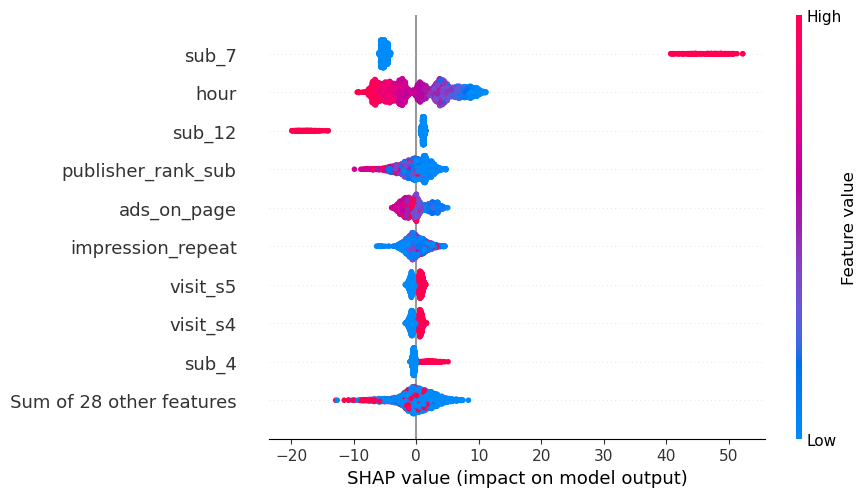

In [91]:
# shap_values_1 = cf.shap_values(X[X.index % 2000 == 0])
shap.plots.beeswarm(shap_values_1['is_clicked']['advertiser_rank_1'] / .0025326 * 100)

 99%|===================| 3095/3117 [00:39<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


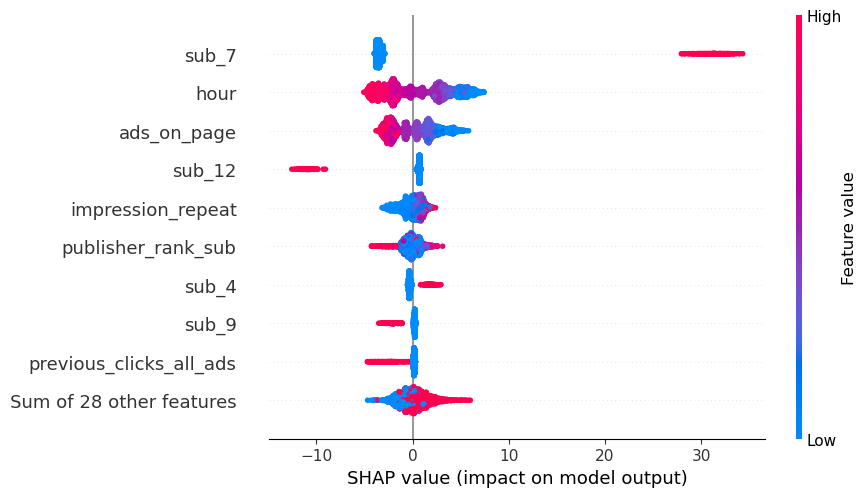

In [93]:
shap_values_1 = cf.shap_values(X[X.index % 1000 == 0])
shap.plots.beeswarm(shap_values_1['is_clicked']['advertiser_rank_1'] / .0025326 * 100)

In [84]:
shap_values_1 = cf.shap_values(X.iloc[0:100, :])


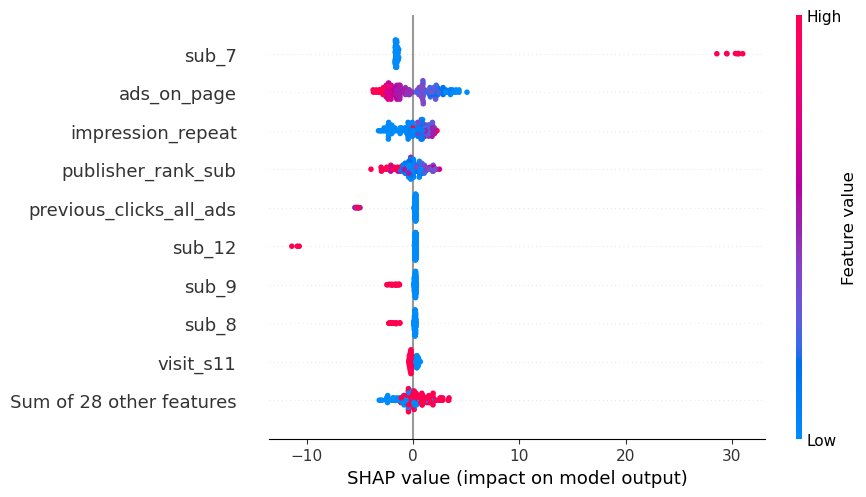

In [85]:
shap.plots.beeswarm(shap_values_1['is_clicked']['advertiser_rank_1'] / .0025326 * 100, show=False)    

# plt.savefig(f"..\\results\\split 1\\figures\\Treatment Effect Shap Values bw Ad 1, 3.jpg", dpi=600,  bbox_inches = 'tight')


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <econml.dml.causal_forest.CausalForestDML object at 0x0000021D900CE550>

In [102]:
X.rename(columns={
    'impression_repeat': 'Repeats',
     'impression_repeat_base_ad': 'Base Ad Repeats',
     'visit_s8': 'Finance',
     'visit_s19': 'Political',
     'visit_s14': 'Lifestyle',
     'visit_s23': 'Sports',
     'visit_s12': 'Health',
     'visit_s17': 'Music',
     'visit_s18': 'Misc.',
     'total_visits': 'Total Pages Visited',
       
}, inplace=True)

In [94]:
shap_df = pd.DataFrame(shap_values_1['is_clicked']['advertiser_rank_3'])

# # Specify the feature names you want to display
# feature_names = ['Feature 1', 'Feature 2', 'Feature 3']

# # Create the beeswarm plot with adjusted feature names
# shap.summary_plot(shap_values_1, X, feature_names=feature_names)

KeyError: 'advertiser_rank_3'

In [11]:
te_ci = cf.const_marginal_effect_interval(X[X.index % 10 == 0])
te_h = np.squeeze(te_ci[1])
te_l = np.squeeze(te_ci[0])
te = (te_h + te_l) / 2
d = {'te': te, 'te_h': te_h, 'te_l': te_l}
te_dataset=pd.DataFrame(data=d)
te_dataset = te_dataset.sort_values('te')
te_dataset = te_dataset.reset_index(drop=True)
te_dataset['pct'] = te_dataset.index / len(te_dataset) * 100


In [12]:

te_dataset

,te,te_h,te_l,pct
0,-0.001628,-0.000697,-0.002560,0.000000
1,-0.001617,-0.000730,-0.002505,0.000319
2,-0.001616,-0.000692,-0.002540,0.000639
3,-0.001614,-0.000891,-0.002338,0.000958
4,-0.001612,-0.000716,-0.002508,0.001278
...,...,...,...,...
313031,0.000158,0.001221,-0.000906,99.998403
313032,0.000159,0.001336,-0.001018,99.998722
313033,0.000168,0.001221,-0.000885,99.999042
313034,0.000171,0.001487,-0.001145,99.999361


In [16]:
te_dataset.loc[15000, :]

te     -0.001233
te_h   -0.000669
te_l   -0.001798
pct     4.791781
Name: 15000, dtype: float64

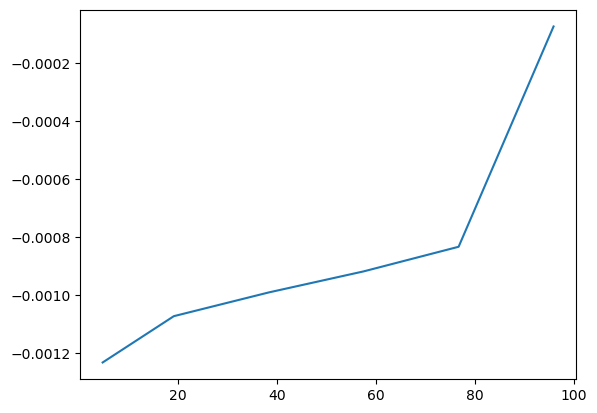

In [13]:
indices = [15000, 60000, 120000, 180000, 240000, 300000]
te_sub = te_dataset.loc[indices, :]
plt.plot(te_sub.pct, te_sub.te)


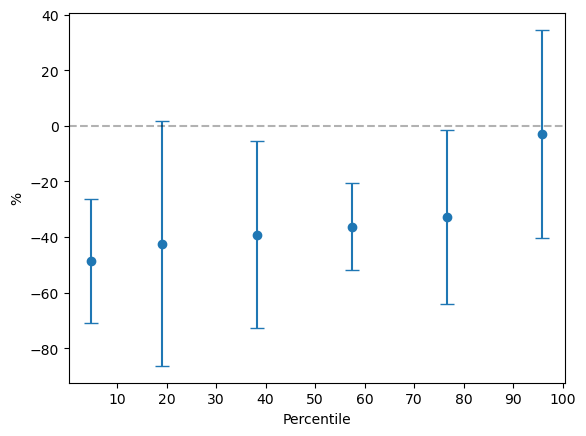

In [14]:
plt.errorbar(te_sub.pct, te_sub.te / 0.0025326 * 100, yerr=(te_sub.te_h-te_sub.te_l) / 2 / 0.0025326 * 100, fmt="o", capsize=5)
plt.xlabel('Percentile')
plt.ylabel('%')
# plt.title("Treatment Effect Heterogeneity")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xticks(np.linspace(10, 100, 10))
# plt.savefig(f"..\\results\\split 1\\figures\\Treatment Effect bw Ad 1, 3.jpg", dpi=600)
plt.show()

In [20]:
m = cf.model_y.fit(X, Y)

In [66]:
# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\M - Rank 1, 3 - Full Data.pkl"
joblib.dump(m, file_name)

['..\\results\\Full Model\\Monopoly\\M - Rank 1, 3 - Full Data.pkl']

In [21]:
m = cf.model_y.fit(X, Y)
# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\M - Rank 1, 3 - Full Data.pkl"
joblib.dump(m, file_name)
e =  cf.model_t.fit(X, T)
# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\E - Rank 1, 3 - Full Data.pkl"
joblib.dump(e, file_name)

In [67]:
# save the model
file_name = f"..\\results\\Full Model\\Monopoly\\E - Rank 1, 3 - Full Data.pkl"
joblib.dump(e, file_name)

['..\\results\\Full Model\\Monopoly\\E - Rank 1, 3 - Full Data.pkl']

In [35]:
te_dataset['e_hat'] = e.predict_proba(X[X.index % 10 == 0])[:,1]

In [36]:
te_dataset['m_hat'] = m.predict(X[X.index % 10 == 0])

In [38]:
te_dataset['ctr_0'] = te_dataset['m_hat']- te_dataset['te'] * te_dataset['e_hat'] 
te_dataset['ctr_3'] = te_dataset['ctr_0'] + te_dataset['te']

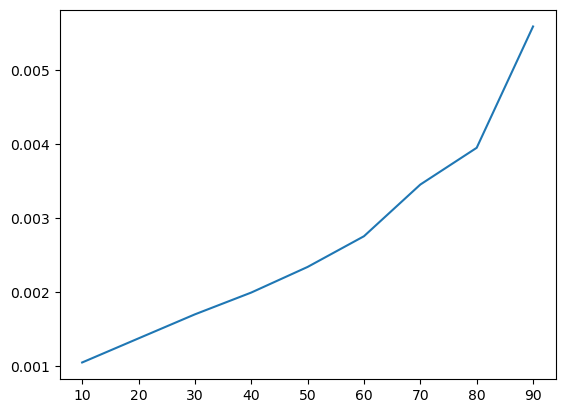

In [64]:
te_dataset = te_dataset.sort_values('ctr_0')
te_dataset = te_dataset.reset_index(drop=True)
te_dataset['pct'] = te_dataset.index / len(te_dataset) * 100
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])

indices = np.floor(percentiles * len(te_dataset) / 100)

# indices = [15000, 60000, 120000, 180000, 240000, 300000]
te_sub = te_dataset.loc[indices, :]
plt.plot(te_sub.pct, te_sub.ctr_0)

<ErrorbarContainer object of 3 artists>

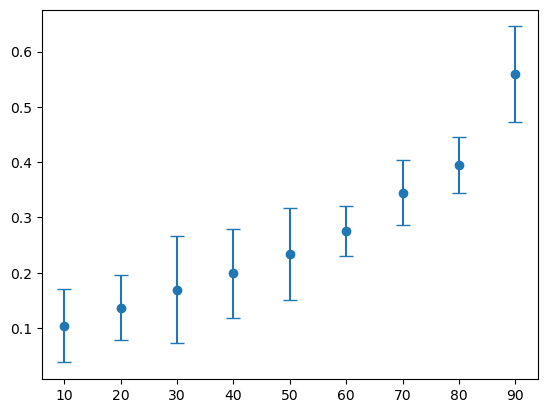

In [72]:
plt.errorbar(te_sub.pct, te_sub.ctr_0 * 100, yerr=(te_sub.te_h-te_sub.te_l) / 2 * 100, fmt="o", capsize=5)


# te_dataset = te_dataset.sort_values('ctr_0')
# te_dataset = te_dataset.reset_index(drop=True)
# te_dataset['pct'] = te_dataset.index / len(te_dataset) * 100

# te_sub_2 = te_dataset.loc[indices, :]

# plt.errorbar(te_sub_2.pct, te_sub_2.ctr_3 * 100, yerr=(te_sub.te_h-te_sub.te_l) / 2 * 100, fmt="o", capsize=5)